<a href="https://colab.research.google.com/github/KunChen-tw/DeepLearning/blob/main/deeplearning1109_Ch7_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXAMPLE of LSTM 1


In [20]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
df = pd.read_csv('AirPassengers.csv')
print(df.head(10))

print(df.tail(10))


Using device: cpu
     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
5  1949-06          135
6  1949-07          148
7  1949-08          148
8  1949-09          136
9  1949-10          119
       Month  #Passengers
134  1960-03          419
135  1960-04          461
136  1960-05          472
137  1960-06          535
138  1960-07          622
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432


# EXAMPLE of LSTM 2

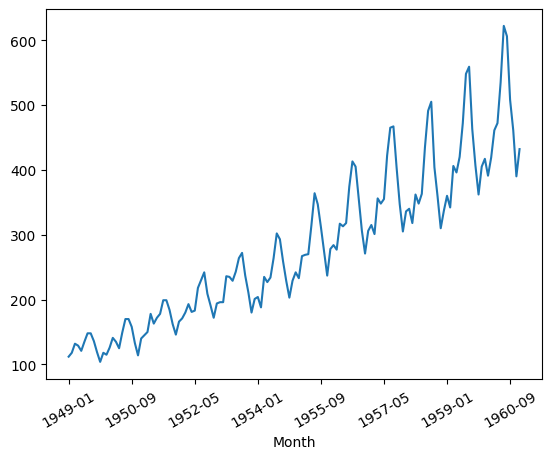

In [21]:
df2 = df.set_index('Month')
df2.plot(legend=None)
plt.xticks(rotation=30)
plt.show()


# EXAMPLE of LSTM 3

In [22]:
# Data preprocessing
dataset = df2[['#Passengers']].values.astype('float32')

# Scale data to [0, 1] range
scaler = MinMaxScaler(feature_range=(0, 1))
print('before scalar', dataset[0:5], dataset[-5:])
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
print('after scalar', dataset[0:5], dataset[-5:])


# Set the look-back window size
look_back = 2

# Function to create dataset
def create_dataset(data, look_back):
    x, y = [], []
    for i in range(len(data) - look_back):
        _x = data[i:(i + look_back)]
        _y = data[i + look_back]
        x.append(_x)
        y.append(_y)
    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))


before scalar [[112.]
 [118.]
 [132.]
 [129.]
 [121.]] [[606.]
 [508.]
 [461.]
 [390.]
 [432.]]
after scalar [[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]] [[0.96911204]
 [0.7799227 ]
 [0.6891892 ]
 [0.55212355]
 [0.6332046 ]]


# EXAMPLE of LSTM 4

In [23]:
# Data division
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

# Reshape the data for LSTM input
trainX = trainX.reshape(-1, look_back, 1).to(device)
testX = testX.reshape(-1, look_back, 1).to(device)
trainY = trainY.to(device)
testY = testY.to(device)


torch.Size([94, 2, 1]) torch.Size([94, 1]) torch.Size([46, 2, 1]) torch.Size([46, 1])


# EXAMPLE of LSTM 5

In [24]:
# Define the LSTM model
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, hidden_size=4, num_layers=1):
        super(TimeSeriesModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h_0, c_0))
        return self.fc(out[:, -1, :])

model = TimeSeriesModel(look_back, hidden_size=5, num_layers=1).to(device)
print(model)


TimeSeriesModel(
  (lstm): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)


# EXAMPLE of LSTM 6

In [25]:
model = TimeSeriesModel(look_back, hidden_size=5, num_layers=1).to(device)
print(model)

# Train the model
num_epochs = 2000
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_model():
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(trainX)
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.5f}")

train_model()


TimeSeriesModel(
  (lstm): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)
Epoch [0/2000], Loss: 0.27590
Epoch [100/2000], Loss: 0.00323
Epoch [200/2000], Loss: 0.00262
Epoch [300/2000], Loss: 0.00194
Epoch [400/2000], Loss: 0.00172
Epoch [500/2000], Loss: 0.00168
Epoch [600/2000], Loss: 0.00165
Epoch [700/2000], Loss: 0.00163
Epoch [800/2000], Loss: 0.00162
Epoch [900/2000], Loss: 0.00161
Epoch [1000/2000], Loss: 0.00161
Epoch [1100/2000], Loss: 0.00161
Epoch [1200/2000], Loss: 0.00161
Epoch [1300/2000], Loss: 0.00161
Epoch [1400/2000], Loss: 0.00161
Epoch [1500/2000], Loss: 0.00161
Epoch [1600/2000], Loss: 0.00161
Epoch [1700/2000], Loss: 0.00160
Epoch [1800/2000], Loss: 0.00160
Epoch [1900/2000], Loss: 0.00160


# EXAMPLE of LSTM 7

In [26]:
# Make predictions
model.eval()
trainPredict = model(trainX).cpu().detach().numpy()
testPredict = model(testX).cpu().detach().numpy()

print(trainY.shape, trainPredict.shape)
print(testY.shape, testPredict.shape)


torch.Size([94, 1]) (94, 1)
torch.Size([46, 1]) (46, 1)


# EXAMPLE of LSTM 8

In [27]:
# Inverse scale the predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.cpu().detach().numpy().reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.cpu().detach().numpy().reshape(-1, 1))

# Calculate RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict))
print(f'Test RMSE: {testScore:.2f}')


Train RMSE: 20.74
Test RMSE: 65.20


# EXAMPLE of LSTM 9

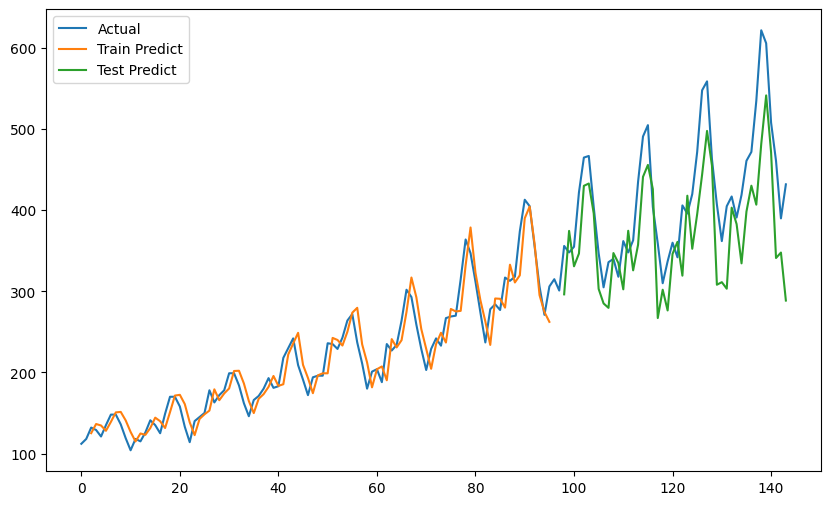

In [28]:
# Initialize data for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
test_start = len(trainPredict) + (look_back * 2)
testPredictPlot[test_start:test_start + len(testPredict), :] = testPredict

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.legend()
plt.show()
